## classification model

In [3]:

import pandas as pd
import logging
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, f1_score,accuracy_score,log_loss
from sklearn.preprocessing import label_binarize
from itertools import cycle
import logging
import pandas as pd
from typing import Tuple 
from torch import nn
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from nltk import download
from nltk.corpus import wordnet as wn
import random
from typing import List, Set
from torch import cuda
from transformers import DistilBertTokenizer, DistilBertModel
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

ROUTE_SYNTHETIC= '../src/data/synthetic_preprocessed.parquet'
df_synthetic = pd.read_parquet(ROUTE_SYNTHETIC)
df_synthetic = df_synthetic[['BUSINESS_DESCRIPTION', 'NAICS_2']]
df_synthetic.rename(columns={'NAICS_2': 'NAICS'}, inplace=True)
print(df_synthetic.head())
print(df_synthetic.columns)
df_synthetic=df_synthetic
naics_counts =df_synthetic['NAICS'].value_counts()

print("Número de filas por cada código NAICS:")
print(naics_counts)


/home/edu/.cache/pypoetry/virtualenvs/zrive-ds-O6CSjbdk-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


                                BUSINESS_DESCRIPTION  NAICS
0  This establishment is engaged in the explorati...     21
1  This business is involved in the mining and qu...     21
2  This company specializes in the mining and pro...     21
3  This establishment is engaged in the explorati...     21
4  This business provides support services for oi...     21
Index(['BUSINESS_DESCRIPTION', 'NAICS'], dtype='object')
Número de filas por cada código NAICS:
NAICS
55    260
21    240
22    240
11    210
92    200
49    109
52    100
44    100
48     91
31     76
32     18
33      6
Name: count, dtype: int64


[nltk_data] Downloading package wordnet to /home/edu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2024-04-24 11:15:13,213 - INFO - Number of rows before EDA: 14182
2024-04-24 11:15:13,214 - INFO - Number of rows after EDA: 11647


NAICS
23    1500
54    1500
56    1159
61     751
33     688
42     650
62     517
81     488
51     380
48     361
72     333
53     331
71     300
55     275
22     272
52     262
31     260
32     259
21     253
44     248
45     240
11     236
92     230
49     154
Name: count, dtype: int64


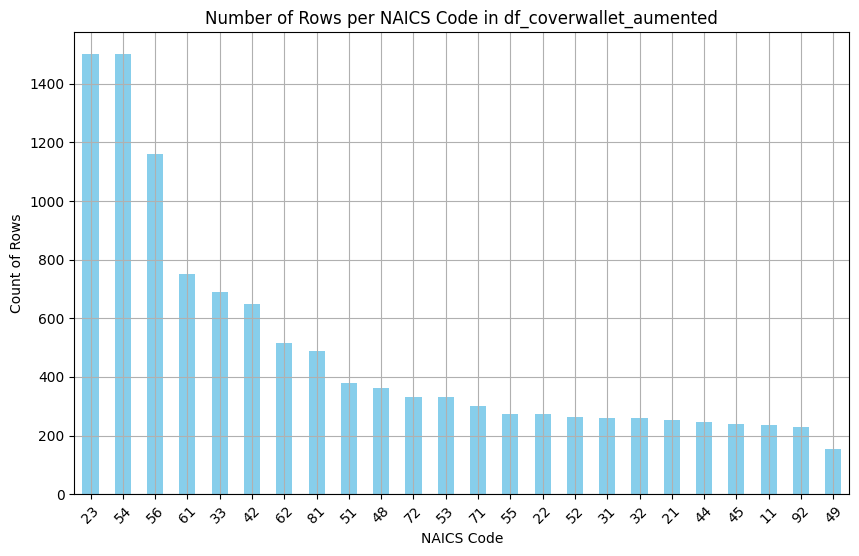

      NAICS                               BUSINESS_DESCRIPTION
10079    11  A greenhouse and nursery operation that grows ...
10098    11  An avocado farm utilizing water-efficient irri...
11334    11  A forestry support service specializing in ref...
10097    11  A diversified farm specializing in the product...
11335    11  A wildlife management service dedicated to the...


In [4]:

import pandas as pd
import random
from typing import List, Set
from nltk.corpus import wordnet as wn
from nltk import download
import logging
from sklearn.model_selection import train_test_split
from typing import Tuple

ROUTE_COVERWALLET= '../src/data/coverwallet.xlsx'

class NAICSRebalancer:
    def __init__(self):
        logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
        download('wordnet')

    def get_synonyms(self, word: str) -> List[str]:
        synonyms: Set[str] = set()
        for syn in wn.synsets(word):
            for lemma in syn.lemmas():
                synonym = lemma.name().replace('_', ' ')
                synonyms.add(synonym)
        synonyms.discard(word)
        return list(synonyms)

    def random_swap(self, sentence: str, n: int) -> str:
        words = sentence.split()
        n = min(n, len(words) // 2)
        for _ in range(n):
            idx1, idx2 = random.sample(range(len(words)), 2)
            words[idx1], words[idx2] = words[idx2], words[idx1]
        return ' '.join(words)

    def augment_description(self, description: str) -> str:
        words = description.split()
        if len(words) < 2:
            return description
        
        new_description = description
        num_swaps = random.randint(1, max(2, len(words) // 2))
        swapped_words = set()
        
        for _ in range(num_swaps):
            swap_word = random.choice(words)
            if swap_word in swapped_words:
                continue
            synonyms = self.get_synonyms(swap_word)
            if synonyms:
                new_word = random.choice(synonyms)
                new_description = new_description.replace(swap_word, new_word, 1)
                swapped_words.add(swap_word)
        
        return self.random_swap(new_description, n=num_swaps)

    def rebalance_df_naics(self, df: pd.DataFrame) -> pd.DataFrame:
        df_2_digits, dataset_train_2_digits, dataset_final_val_2_digits = truncate_naics_and_prepare_data(df, 'NAICS', 2)
        naics_counts = df_2_digits['NAICS'].value_counts()
        underrepresented_naics = naics_counts[naics_counts < 10].index
        overrepresented_naics = naics_counts[naics_counts > 1500].index
        new_rows = []

        for naics_code in underrepresented_naics:
            needed_rows = 10 - naics_counts[naics_code]
            original_rows = df_2_digits[df_2_digits['NAICS'] == naics_code]
            while needed_rows > 0:
                for _, row in original_rows.iterrows():
                    if needed_rows <= 0:
                        break
                    new_description = self.augment_description(row['BUSINESS_DESCRIPTION'])
                    new_rows.append({'NAICS': naics_code, 'BUSINESS_DESCRIPTION': new_description})
                    needed_rows -= 1

        for naics_code in overrepresented_naics:
            rows_to_keep = df_2_digits[df_2_digits['NAICS'] == naics_code].sample(n=1500, random_state=42)
            df_2_digits = pd.concat([df_2_digits[df_2_digits['NAICS'] != naics_code], rows_to_keep], ignore_index=True)

        new_rows_df = pd.DataFrame(new_rows)
        df_2_digits = pd.concat([df_2_digits, new_rows_df], ignore_index=True)

        return df_2_digits
    
def truncate_naics_and_prepare_data(df: pd.DataFrame, column_name: str, num_digits: int) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    
    df=df.dropna()
    
    if not isinstance(num_digits, int) or num_digits <= 0:
        logging.error("Number of digits must be a positive integer")
        raise ValueError("Number of digits must be a positive integer")

    df_coverwallet_copy = df.copy()

    def truncate_code(code):
        try:
            return str(code)[:num_digits]
        except Exception as e:
            logging.exception(f"Error truncating code: {code}")
            return code

    df_coverwallet_copy [column_name] = df_coverwallet_copy [column_name].apply(truncate_code)
    df_coverwallet_copy [column_name] = df_coverwallet_copy [column_name].astype(str)
    df_coverwallet_copy_train, df_coverwallet_copy_val = train_test_split(df_coverwallet_copy , test_size=0.15, shuffle=True, random_state=42)
    

    return df_coverwallet_copy , df_coverwallet_copy_train, df_coverwallet_copy_val




df_coverwallet_aumentation = pd.read_excel(ROUTE_COVERWALLET)
rebalancer = NAICSRebalancer()
df_naics_rebalanced = rebalancer.rebalance_df_naics(df_coverwallet_aumentation)
df_coverwallet_aumented = pd.concat([df_naics_rebalanced, df_synthetic], ignore_index=True)

df_coverwallet_aumented['NAICS'] = df_coverwallet_aumented['NAICS'].astype(str)

df_coverwallet_aumented.sort_values(by='NAICS', inplace=True)

logging.info(f"Number of rows before EDA: {len(df_coverwallet_aumentation)}")
logging.info(f"Number of rows after EDA: {len(df_coverwallet_aumented)}")

naics_counts = df_coverwallet_aumented['NAICS'].value_counts()
print(naics_counts)

naics_counts.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.xlabel('NAICS Code')
plt.ylabel('Count of Rows')
plt.title('Number of Rows per NAICS Code in df_coverwallet_aumented')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

print(df_coverwallet_aumented.head())
df_2_digits=df_coverwallet_aumented



In [5]:
import torch
import numpy as np
from torch.utils.data import Dataset
from transformers import DistilBertTokenizer, DistilBertModel
from torch import nn
from sklearn.metrics.pairwise import cosine_similarity

class CustomDataset(Dataset):
    def __init__(self, dataframe, max_len):
        self.tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
        self.texts = np.array(dataframe['BUSINESS_DESCRIPTION'].astype(str))
        self.targets = np.array(dataframe['NAICS'].astype(int))
        self.max_len = max_len
        self.model = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.classifier = nn.Linear(self.model.config.dim, len(np.unique(self.targets)))

        # No need to freeze any layers; all parameters are left trainable by default

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        target = self.targets[idx]
        inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=self.max_len)
        
        outputs = self.model(**inputs)
        
        embeddings = outputs.last_hidden_state[:, 0, :]  # Get the embeddings from the last hidden state
        logits = self.classifier(embeddings)  # Pass embeddings through the classifier
        label = torch.tensor(target, dtype=torch.long)
        
        return {
            'embeddings': embeddings,
            'label': label,
        }

In [6]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'



In [7]:

MAX_LEN = 128

 
def dataset_to_dataframe(dataset):
    data = []
    for i in range(len(dataset)):
        item = dataset[i]
        embeddings = item['embeddings'].squeeze().detach().numpy() 
        label = item['label'].item()  
        data.append({
            'label': label,
            'embeddings': embeddings  
        })
    return pd.DataFrame(data)

data=CustomDataset(df_2_digits, MAX_LEN)

df_embeddings=dataset_to_dataframe(data)
df_2_digits=df_embeddings

logging.info("DF: %s", df_2_digits.head())


2024-04-24 11:27:11,928 - INFO - DF:    label                                         embeddings
0     11  [-0.41822138, -0.1345889, -0.4076835, -0.28181...
1     11  [-0.4553398, -0.22250879, -0.31727314, -0.0733...
2     11  [-0.53136826, -0.15298308, -0.43377197, -0.127...
3     11  [-0.6172706, -0.3867334, -0.54889846, -0.26367...
4     11  [-0.5341572, -0.28143314, -0.67108476, -0.2581...


2024-04-24 11:32:56,105 - INFO - F1 Score: 0.694749


Confusion Matrix:
 [[ 43   0   0   0   0   0   0   1   0   0   0   0   0   0   0   1   0   2
    0   0   0   0   0   0]
 [  0  48   0   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0  52   0   0   0   1   0   0   0   0   0   1   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0 256   0   2   9   6   1   0   0   0   1   0   4   8   0  13
    0   0   0   0   0   0]
 [  1   0   0   0  27   1   2   7   0   7   0   1   0   0   0   1   0   0
    0   0   0   4   1   0]
 [  0   0   0   4   2  24   8   6   1   1   0   0   0   0   0   3   0   0
    0   1   0   0   2   0]
 [  0   0   1  12   1   2  92  14   3   0   1   0   1   0   0   4   0   3
    1   2   0   0   1   0]
 [  0   0   0   3   9   3  16  72   5   6   3   0   2   0   2   5   0   1
    0   1   0   1   1   0]
 [  0   0   0   3   0   0   1   3  35   0   0   0   1   0   0   0   0   0
    1   0   1   2   3   0]
 [  0   0   0   1   5   2   1   7   1  20   1   0   0   0   0   0   0   

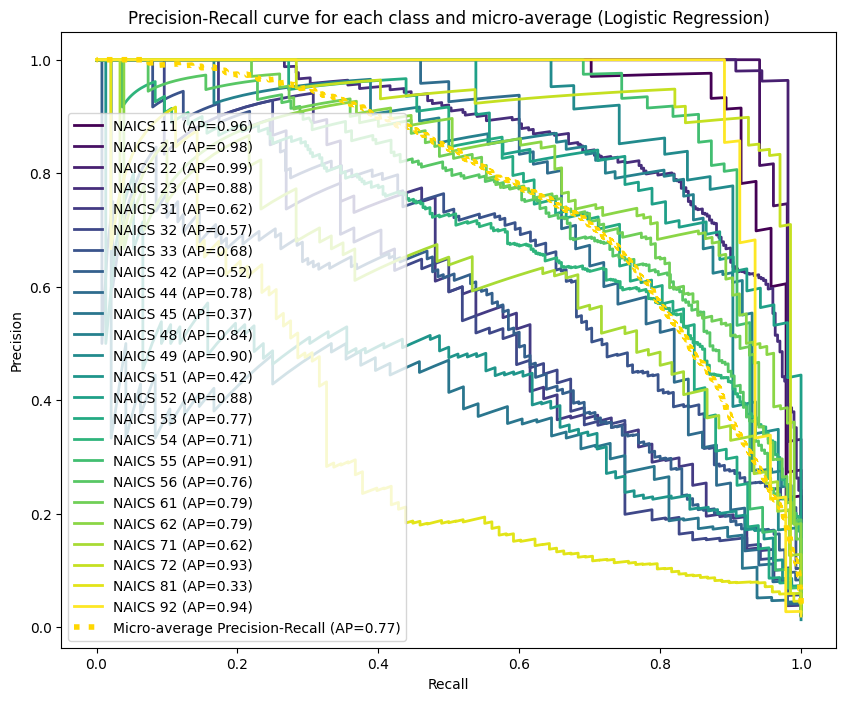

2024-04-24 11:32:57,152 - INFO - Average F1 Score Logistic Regression: 0.733556


' \nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, f1_score\nfrom sklearn.model_selection import StratifiedKFold, train_test_split\nfrom sklearn.preprocessing import label_binarize\nfrom itertools import cycle\nimport logging\n\n# Configurar logging para mostrar información de las métricas\nlogging.basicConfig(level=logging.INFO, format=\'%(asctime)s - %(levelname)s - %(message)s\')\n\n# Asumiendo que df_2_digits es el DataFrame con los datos\nX = np.stack(df_2_digits[\'embeddings\'].apply(lambda x: np.array(x).flatten()))\ny = df_2_digits[\'label\'].to_numpy()\n\n# Dividir los datos en un conjunto para cross-validation (90%) y un conjunto final de test (10%)\nX_cross_val, X_final_test, y_cross_val, y_final_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)\n\n# Configurando la validación 

In [8]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, f1_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
df_training, df_val = train_test_split(df_2_digits, test_size=0.2, random_state=42, stratify=df_2_digits['label'])


X_train = np.stack(df_training['embeddings'].apply(lambda x: np.array(x).flatten()))
y_train = df_training['label'].to_numpy()

X_val = np.stack(df_val['embeddings'].apply(lambda x: np.array(x).flatten()))
y_val = df_val['label'].to_numpy()


model = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
model.fit(X_train, y_train)
y_val_pred = model.predict(X_val)
y_val_proba = model.predict_proba(X_val)

conf_matrix = confusion_matrix(y_val, y_val_pred)
report = classification_report(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred, average='weighted')

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)
logging.info("F1 Score: %f", f1)

unique_classes = np.unique(y_train)  
y_val_binarized = label_binarize(y_val, classes=unique_classes)


precision = dict()
recall = dict()
average_precision = dict()
f1_scores = []


colors = cycle(plt.cm.viridis(np.linspace(0, 1, len(unique_classes))))
plt.figure(figsize=(10, 8))

for i, color in zip(range(len(unique_classes)), colors):
    precision[i], recall[i], _ = precision_recall_curve(y_val_binarized[:, i], y_val_proba[:, i])
    average_precision[i] = average_precision_score(y_val_binarized[:, i], y_val_proba[:, i])
    f1 = (2 * precision[i] * recall[i]) / (np.nan_to_num(precision[i]) + np.nan_to_num(recall[i]))
    f1_scores.append(np.nanmax(f1))
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='NAICS {0} (AP={1:0.2f})'.format(unique_classes[i], average_precision[i])) 

precision["micro"], recall["micro"], _ = precision_recall_curve(y_val_binarized.ravel(), y_val_proba.ravel())
average_precision["micro"] = average_precision_score(y_val_binarized, y_val_proba, average="micro")

plt.plot(recall["micro"], precision["micro"], color='gold', linestyle=':', linewidth=4,
         label='Micro-average Precision-Recall (AP={0:0.2f})'.format(average_precision["micro"]))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for each class and micro-average (Logistic Regression)')
plt.legend(loc="best")
plt.show()

f1_average = np.mean(f1_scores)
logging.info("Average F1 Score Logistic Regression: %f", f1_average)
''' 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, f1_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import label_binarize
from itertools import cycle
import logging

# Configurar logging para mostrar información de las métricas
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Asumiendo que df_2_digits es el DataFrame con los datos
X = np.stack(df_2_digits['embeddings'].apply(lambda x: np.array(x).flatten()))
y = df_2_digits['label'].to_numpy()

# Dividir los datos en un conjunto para cross-validation (90%) y un conjunto final de test (10%)
X_cross_val, X_final_test, y_cross_val, y_final_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Configurando la validación cruzada sobre el 90% del conjunto
skf = StratifiedKFold(n_splits=5)
f1_scores = []

# Ciclo a través de los pliegues de validación cruzada
for train_index, test_index in skf.split(X_cross_val, y_cross_val):
    X_train, X_test = X_cross_val[train_index], X_cross_val[test_index]
    y_train, y_test = y_cross_val[train_index], y_cross_val[test_index]

    model = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    # Calculando y registrando las métricas por pliegue
    report = classification_report(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)
    logging.info("\n%s\n", report)
    logging.info("F1 Score: %f", f1)

# Calculando el promedio de F1-score de todos los pliegues
f1_average = np.mean(f1_scores)
logging.info("Average F1 Score Logistic Regression: %f", f1_average)

# Evaluación en el conjunto final de test
model_final = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
model_final.fit(X_cross_val, y_cross_val)  # Entrenamos con todo el conjunto de cross-validation
y_final_pred = model_final.predict(X_final_test)
y_final_proba = model_final.predict_proba(X_final_test)
final_report = classification_report(y_final_test, y_final_pred)
final_f1 = f1_score(y_final_test, y_final_pred, average='weighted')
logging.info("\nFinal Test Set Classification Report:\n%s\n", final_report)
logging.info("Final Test Set F1 Score: %f", final_f1)

# Binarizar las etiquetas del conjunto final para visualización
unique_classes = np.unique(y_cross_val)
y_final_test_binarized = label_binarize(y_final_test, classes=unique_classes)

# Calcular y graficar las métricas para el conjunto final
precision = dict()
recall = dict()
average_precision = dict()
colors = cycle(plt.cm.viridis(np.linspace(0, 1, len(unique_classes))))
plt.figure(figsize=(10, 8))

for i, color in zip(range(len(unique_classes)), colors):
    precision[i], recall[i], _ = precision_recall_curve(y_final_test_binarized[:, i], y_final_proba[:, i])
    average_precision[i] = average_precision_score(y_final_test_binarized[:, i], y_final_proba[:, i])
    plt.plot(recall[i], precision[i], color=color, lw=2, label='NAICS {0} (AP={1:0.2f})'.format(unique_classes[i], average_precision[i]))

precision["micro"], recall["micro"], _ = precision_recall_curve(y_final_test_binarized.ravel(), y_final_proba.ravel())
average_precision["micro"] = average_precision_score(y_final_test_binarized, y_final_proba, average="micro")
plt.plot(recall["micro"], precision["micro"], color='gold', linestyle=':', linewidth=4,
         label='Micro-average Precision-Recall (AP={0:0.2f})'.format(average_precision["micro"]))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for each class and micro-average (Logistic Regression)')
plt.legend(loc="best")
plt.grid(True)
plt.show()

''' 

random forest

2024-04-23 23:13:50,155 - INFO - F1 Score Random Forest: 0.562565


Confusion Matrix:
 [[ 41   1   0   1   0   0   0   0   0   0   0   0   0   0   0   1   0   3
    0   0   0   0   0   0]
 [  0  46   0   4   0   0   0   0   0   0   1   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0  49   0   0   0   1   1   0   0   0   0   0   0   0   1   2   0
    0   0   0   0   0   0]
 [  0   0   0 256   0   0  11   2   0   0   0   0   0   0   1  17   0  13
    0   0   0   0   0   0]
 [  1   0   0   0  23   1   5   5   0   5   1   0   0   0   0   4   0   4
    1   1   0   1   0   0]
 [  0   0   0   7   0   8  14  11   0   0   0   0   0   0   0   8   1   1
    1   0   0   1   0   0]
 [  0   0   0  37   0   0  66  12   0   0   0   0   0   0   0  11   0   7
    0   4   0   0   1   0]
 [  0   0   0  15   6   0  24  47   0   4   1   0   0   0   0  11   0  15
    0   1   0   5   1   0]
 [  1   0   0   6   0   0   3   5  27   0   1   0   0   0   0   1   0   3
    1   0   0   2   0   0]
 [  0   0   0   3   3   0   3  10   0  12   0   0   0   0   0   1   0   

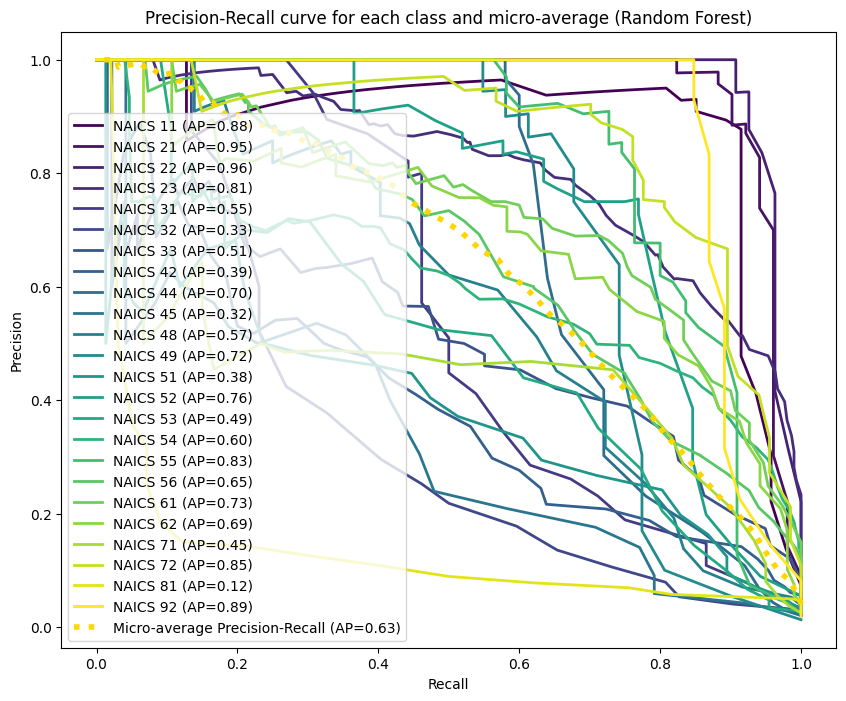

2024-04-23 23:13:50,671 - INFO - Average F1 Score Random Forest: 0.644475


In [14]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, f1_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_val_pred = rf_model.predict(X_val)
y_val_proba = rf_model.predict_proba(X_val)

conf_matrix = confusion_matrix(y_val, y_val_pred)
report = classification_report(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred, average='weighted')

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report Random Forest:\n", report)
logging.info("F1 Score Random Forest: %f", f1)


unique_classes = np.unique(y_train) 
y_val_binarized = label_binarize(y_val, classes=unique_classes)

colors = cycle(plt.cm.viridis(np.linspace(0, 1, len(unique_classes))))

precision = dict()
recall = dict()
average_precision = dict()
f1_scores = []

for i, code in enumerate(unique_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_val_binarized[:, i], y_val_proba[:, i])
    average_precision[i] = average_precision_score(y_val_binarized[:, i], y_val_proba[:, i])
    if np.any(precision[i]) and np.any(recall[i]):
        f1 = (2 * precision[i] * recall[i]) / (np.nan_to_num(precision[i]) + np.nan_to_num(recall[i]))
        f1_scores.append(np.nanmax(f1))
    else:
        f1_scores.append(0)

plt.figure(figsize=(10, 8))
for i, (color, code) in enumerate(zip(colors, unique_classes)):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='NAICS {0} (AP={1:0.2f})'.format(code, average_precision[i])) 

precision["micro"], recall["micro"], _ = precision_recall_curve(y_val_binarized.ravel(), y_val_proba.ravel())
average_precision["micro"] = average_precision_score(y_val_binarized, y_val_proba, average="micro")

plt.plot(recall["micro"], precision["micro"], color='gold', linestyle=':', linewidth=4,
         label='Micro-average Precision-Recall (AP={0:0.2f})'.format(average_precision["micro"]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for each class and micro-average (Random Forest)')
plt.legend(loc="best")
plt.show()

f1_average = np.mean(f1_scores)
logging.info("Average F1 Score Random Forest: %f", f1_average)


svm

2024-04-23 23:15:58,557 - INFO - F1 Score SVM: 0.644680


Confusion Matrix:
 [[ 43   0   0   1   0   0   0   1   0   0   0   0   0   0   0   1   0   1
    0   0   0   0   0   0]
 [  0  48   0   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0  50   1   0   0   1   1   0   0   0   0   0   0   0   0   1   0
    0   0   0   0   0   0]
 [  0   0   0 261   0   0   7   2   0   0   1   0   0   0   4  12   0  13
    0   0   0   0   0   0]
 [  1   0   0   1  23   2   4   9   0   5   0   0   0   0   0   3   0   2
    0   1   0   1   0   0]
 [  0   0   0   5   1  12  15   9   0   2   0   0   0   0   0   4   0   2
    0   0   1   1   0   0]
 [  0   0   0  23   0   0  85  13   0   0   1   0   1   0   0   6   0   7
    0   1   0   0   1   0]
 [  1   0   0  16   6   1  16  65   0   5   2   0   0   0   0  10   0   2
    0   2   0   2   2   0]
 [  2   0   0   3   0   0   2  11  26   0   0   0   1   0   0   1   0   1
    1   0   0   2   0   0]
 [  0   0   0   1   4   2   0   8   0  19   1   0   0   0   0   1   0   

/tmp/ipykernel_8085/1549829771.py:55: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision[i] * recall[i]) / (np.nan_to_num(precision[i]) + np.nan_to_num(recall[i]))
/tmp/ipykernel_8085/1549829771.py:55: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision[i] * recall[i]) / (np.nan_to_num(precision[i]) + np.nan_to_num(recall[i]))


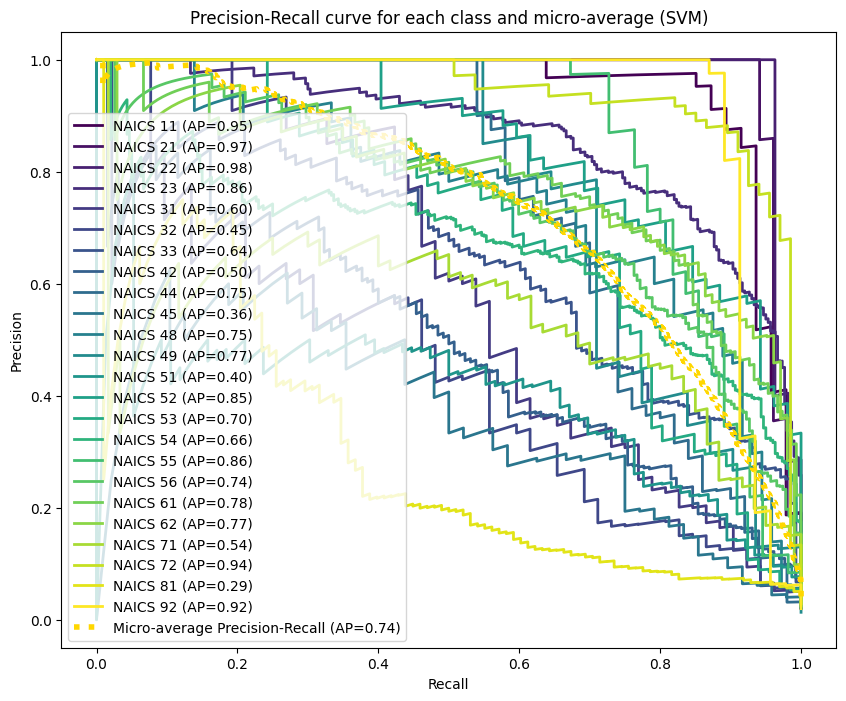

2024-04-23 23:15:59,403 - INFO - Average F1 Score SVM: 0.704455


In [15]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, f1_score, accuracy_score
from sklearn.preprocessing import label_binarize
import logging
from itertools import cycle

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


X_train = np.stack(df_training['embeddings'].apply(lambda x: np.array(x).flatten()))
y_train = df_training['label'].to_numpy()

X_val = np.stack(df_val['embeddings'].apply(lambda x: np.array(x).flatten()))
y_val = df_val['label'].to_numpy()

svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)

y_val_pred = svm_model.predict(X_val)
y_val_proba = svm_model.predict_proba(X_val)  


conf_matrix = confusion_matrix(y_val, y_val_pred)
report = classification_report(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred, average='weighted')

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report SVM:\n", report)
logging.info("F1 Score SVM: %f", f1)


unique_classes = np.unique(y_train) 
y_val_binarized = label_binarize(y_val, classes=unique_classes)


precision = dict()
recall = dict()
average_precision = dict()

colors = cycle(plt.cm.viridis(np.linspace(0, 1, len(unique_classes))))

plt.figure(figsize=(10, 8))

f1_scores = []
for i, (color, code) in enumerate(zip(colors, unique_classes)):
    precision[i], recall[i], _ = precision_recall_curve(y_val_binarized[:, i], y_val_proba[:, i])
    average_precision[i] = average_precision_score(y_val_binarized[:, i], y_val_proba[:, i])
    f1 = 2 * (precision[i] * recall[i]) / (np.nan_to_num(precision[i]) + np.nan_to_num(recall[i]))
    f1_scores.append(np.nanmax(f1))
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='NAICS {0} (AP={1:0.2f})'.format(code, average_precision[i]))  


precision["micro"], recall["micro"], _ = precision_recall_curve(y_val_binarized.ravel(), y_val_proba.ravel())
average_precision["micro"] = average_precision_score(y_val_binarized, y_val_proba, average="micro")


plt.plot(recall["micro"], precision["micro"],
         label='Micro-average Precision-Recall (AP={0:0.2f})'.format(average_precision["micro"]),
         color='gold', linestyle=':', linewidth=4)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for each class and micro-average (SVM)')
plt.legend(loc="best")
plt.show()

f1_average = np.mean(f1_scores)
logging.info("Average F1 Score SVM: %f", f1_average)


lda

2024-04-23 23:16:00,573 - INFO - F1 Score LDA: 0.688815
2024-04-23 23:16:00,575 - INFO - Mean Classification Error: 0.310636
/home/edu/.cache/pypoetry/virtualenvs/zrive-ds-O6CSjbdk-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
2024-04-23 23:16:00,588 - INFO - Mean Log Loss: 2.279306


Confusion Matrix:
 [[ 42   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   3
    0   0   0   0   1   0]
 [  0  48   0   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0  51   0   0   0   1   0   0   0   0   0   1   0   0   0   0   0
    0   0   0   0   1   0]
 [  0   0   0 244   0   3   5   5   0   1   1   0   0   0   5  11   0  19
    0   0   0   0   6   0]
 [  1   0   0   0  29   1   2   6   0   7   0   0   0   0   0   1   0   1
    0   1   0   2   1   0]
 [  0   0   0   4   2  23  10   6   1   2   0   0   0   0   0   2   0   0
    0   0   0   0   2   0]
 [  1   0   0  15   1   3  85  12   2   2   1   0   1   0   1   4   0   3
    1   3   0   0   3   0]
 [  0   0   0   3   8   4  15  73   3  10   2   0   2   0   0   3   0   1
    0   1   0   2   3   0]
 [  0   0   0   2   0   0   0   7  34   0   0   0   1   0   0   0   0   0
    1   0   1   2   2   0]
 [  0   0   0   0   3   4   1   6   2  23   1   0   0   0   0   0   0   

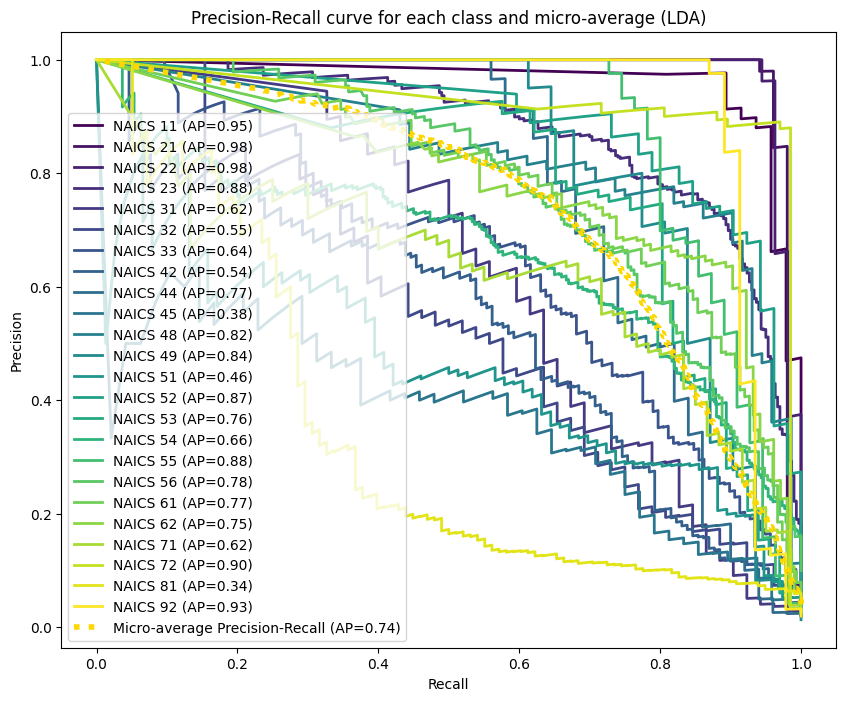

2024-04-23 23:16:01,617 - INFO - Average F1 Score LDA: 0.730083


In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, f1_score, log_loss
from sklearn.preprocessing import label_binarize
from itertools import cycle
import logging


logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

X_train = np.stack(df_training['embeddings'].apply(lambda x: np.array(x).flatten()))
y_train = df_training['label'].to_numpy()

X_val = np.stack(df_val['embeddings'].apply(lambda x: np.array(x).flatten()))
y_val = df_val['label'].to_numpy()

lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)

y_val_pred = lda_model.predict(X_val)
y_val_proba = lda_model.predict_proba(X_val)


conf_matrix = confusion_matrix(y_val, y_val_pred)
report = classification_report(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred, average='weighted')

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report LDA:\n", report)
logging.info("F1 Score LDA: %f", f1)

classification_errors = 1 - np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
mean_classification_error = np.mean(classification_errors)
logging.info("Mean Classification Error: %f", mean_classification_error)

logloss = log_loss(y_val, y_val_proba)
logging.info("Mean Log Loss: %f", logloss)

unique_classes = np.unique(y_train)  
y_val_binarized = label_binarize(y_val, classes=unique_classes)


colors = cycle(plt.cm.viridis(np.linspace(0, 1, len(unique_classes))))

precision = dict()
recall = dict()
average_precision = dict()
f1_scores = []

plt.figure(figsize=(10, 8))

for i, (color, code) in enumerate(zip(colors, unique_classes)):
    precision[i], recall[i], _ = precision_recall_curve(y_val_binarized[:, i], y_val_proba[:, i])
    average_precision[i] = average_precision_score(y_val_binarized[:, i], y_val_proba[:, i])
    f1 = (2 * precision[i] * recall[i]) / (np.nan_to_num(precision[i]) + np.nan_to_num(recall[i]))
    f1_scores.append(np.nanmax(f1))
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='NAICS {0} (AP={1:0.2f})'.format(code, average_precision[i]))  

precision["micro"], recall["micro"], _ = precision_recall_curve(y_val_binarized.ravel(), y_val_proba.ravel())
average_precision["micro"] = average_precision_score(y_val_binarized, y_val_proba, average="micro")

plt.plot(recall["micro"], precision["micro"], color='gold', linestyle=':', linewidth=4,
         label='Micro-average Precision-Recall (AP={0:0.2f})'.format(average_precision["micro"]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for each class and micro-average (LDA)')
plt.legend(loc="best")
plt.show()

f1_average = np.mean(f1_scores)
logging.info("Average F1 Score LDA: %f", f1_average)

